In [4]:
import sys
sys.path.append("..") # this adds to path parent directory in order to import utils file
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pickle
import random
from tqdm import tqdm
import numpy as np
import statsmodels.api as sm
from scipy.stats import wasserstein_distance
from sklearn.manifold import MDS
from mpl_toolkits import mplot3d
from scipy.spatial import distance
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans, AffinityPropagation, DBSCAN, FeatureAgglomeration
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from IPython.display import clear_output, Image, display
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import AffinityPropagation
from itertools import cycle
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA
import gmm_utils

In [2]:
%load_ext autoreload
import importlib
importlib.reload(gmm_utils)

elbowAnalysis
silhouetteAnalyis
bicAicAnalysis


<module 'gmm_utils' from '/home/mada/ml/single-cell-sota/gmm/gmm_utils.py'>

In [8]:
def loadData(inputDataset):
    """
    Load input dataset
    """
    if inputDataset == 'brainCIDR':
        path = '../input/brainCIDR/'
        df = pd.read_csv(f"{path}brainTags.csv", index_col = 0).T
        truth = pd.read_pickle(f'{path}truth.pkl')
    
    if inputDataset == 'pancreaticIsletCIDR':
        path = '../input/pancreaticIsletCIDR/'
        df = pd.read_csv(f"{path}pancreaticIsletTags.csv", index_col = 0).T
        truth = pd.read_pickle(f'{path}truth.pkl')
    
    if inputDataset == 'deng':
        path = '../input/deng/'
        df = pd.read_csv(f"{path}deng.csv", index_col = 0).T
        truth = pd.read_pickle(f'{path}truth.pkl')
    return df, truth

In [9]:
datasetName = 'brainCIDR'
df, truth = loadData(datasetName)
print(df.shape, truth.shape)

(420, 22085) (420, 2)


In [10]:
params={}
params['scaler'] = 'standard'

## Scale cells or genes?

In [11]:
scaledDf = StandardScaler().fit_transform(df)

In [12]:
# df =  RobustScaler().fit_transform(df)

## Dimensionality reduction

#### PCA

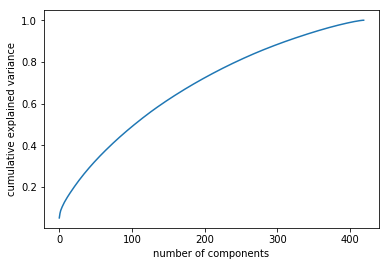

In [14]:
pca = PCA().fit(scaledDf)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [22]:
pca = PCA(.9).fit(scaledDf)


In [25]:
n_comp = pca.n_components_
n_comp

314

In [26]:
n_comp = 8

pc = PCA(n_components=8).fit_transform(scaledDf)

In [29]:
def bestGMM(pc, c_min, c_max):
    print('Best score corresponds to the minimum values of AIC/BIC')
    bic = []
    aic = []
    sil = []
    valid = []
    invalid = []
    outliers = []
    numberOfClusters = range (c_min, c_max)
    for n in numberOfClusters:
        model = GaussianMixture(n, covariance_type ='full', random_state = 0).fit(pc)
        clusters = model.predict(pc)
        ns = list(zip(*sorted(Counter(clusters).items())))[1]
        ns = np.array(ns)
        valid.append(len(ns[ns>=10]))
        invalid.append(len(ns[ns<10]))
        outliers.append(np.sum(ns[ns<10]))
        print(f'{n} : Total {len(ns)}, valid(#>=10) {len(ns[ns>=10])}, invalid {len(ns[ns<10])}, outliers {np.sum(ns[ns<10])}' )
        bic.append(model.bic(pc))
        aic.append(model.aic(pc))
        sil.append(metrics.silhouette_score(pc,clusters ,metric='euclidean', sample_size=None, random_state=None))
    #     plt.figure()
    #     plt.scatter(numberOfClusters, invalid, label = 'nb invalid clusters')

    plt.plot(numberOfClusters, bic, label = 'BIC')
    plt.plot(numberOfClusters, aic, label = 'AIC')
    plt.legend()
    plt.title('BIC/AIC')
    plt.xlabel('n_components')
    plt.show()
    
    plt.figure()
    plt.plot(np.arange(len(sil)), sil, label = 'sil')
    return valid, invalid, outliers, sil

Best score corresponds to the minimum values of AIC/BIC
3 : Total 3, valid(#>=10) 2, invalid 1, outliers 1
4 : Total 4, valid(#>=10) 3, invalid 1, outliers 1
5 : Total 5, valid(#>=10) 3, invalid 2, outliers 2
6 : Total 6, valid(#>=10) 4, invalid 2, outliers 2
7 : Total 7, valid(#>=10) 4, invalid 3, outliers 3
8 : Total 8, valid(#>=10) 5, invalid 3, outliers 3
9 : Total 9, valid(#>=10) 5, invalid 4, outliers 4
10 : Total 10, valid(#>=10) 6, invalid 4, outliers 4
11 : Total 11, valid(#>=10) 6, invalid 5, outliers 13
12 : Total 12, valid(#>=10) 6, invalid 6, outliers 14
13 : Total 13, valid(#>=10) 6, invalid 7, outliers 18
14 : Total 14, valid(#>=10) 7, invalid 7, outliers 18
15 : Total 15, valid(#>=10) 8, invalid 7, outliers 10
16 : Total 16, valid(#>=10) 8, invalid 8, outliers 19
17 : Total 17, valid(#>=10) 9, invalid 8, outliers 19
18 : Total 18, valid(#>=10) 10, invalid 8, outliers 16
19 : Total 19, valid(#>=10) 10, invalid 9, outliers 23


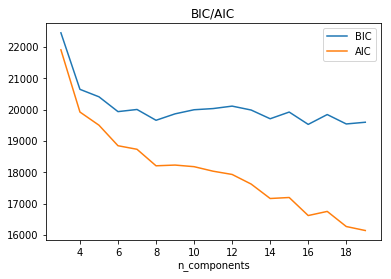

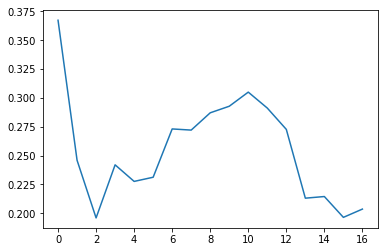

In [30]:
res = bestGMM(pc, 3, 20)

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html 
The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.